#### Functions (IGNORE)

In [1]:
# import packages that will be used for analysis
import random
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(4)
np.random.seed(4)

##### Collect Stock Data

In [2]:
import yfinance as yf
missing_data_tickers = [] # use this as a list of tickers with missing data

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [3]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [4]:
import pandas as pd

# Get the adjusted close prices
adj_close_sector_etf = {}

# Create adjusted close price only listing of sector ETFs
def get_adjusted_closed_price(nested_dict, tickers, periods):
    for period in periods:
        stock_price_df = pd.DataFrame()  # Create a new DataFrame for each period
        for ticker in tickers:
            stock_price_df[ticker] = nested_dict[period][ticker]['Adj Close']
        
        adj_close_sector_etf[period] = stock_price_df  # Store the complete DataFrame for the period
    
    return adj_close_sector_etf

##### Relative Strength Index

In [5]:
def calculate_rsi(data, window):
    """
    Calculate the Relative Strength Index (RSI) for a given stock data series.

    Parameters:
    data (pd.Series): A pandas series of adjusted close prices.
    window (int): The lookback period for RSI calculation, default is 14.

    Returns:
    pd.Series: RSI values.
    """
    delta = data.diff()  # Difference in price from previous price
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # Average gain
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()  # Average loss
    
    # Avoid division by zero, especially at the beginning of the dataset
    rs = gain / loss.replace(0, np.nan)  
    
    # RSI formula
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [6]:
# create rsi value in sector etf dataframe

def rsi_value(nested_dict,periods,tickers,window):
    for period in periods:
        for ticker in tickers:
            nested_dict[period][ticker]['RSI'] = calculate_rsi(nested_dict[period][ticker]['Adj Close'],window)

    return nested_dict

In [7]:
import numpy as np

def create_rsi_signal(nested_dict, periods, tickers):
    """
    Adds a 'Signal' column to the nested dictionary based on RSI values.

    Parameters:
    - nested_dict: A nested dictionary where each period contains dataframes for tickers.
                   Each dataframe should have an 'RSI' column.
    - periods: A list of periods to iterate over.
    - tickers: A list of tickers to process within each period.

    Returns:
    - The modified nested dictionary with new 'Signal' columns.
    """
    
    for period in periods:
        for ticker in tickers:
            # Create the 'Signal' column using np.where
            nested_dict[period][ticker]['Signal'] = np.where(
                nested_dict[period][ticker]['RSI'] < 30, 'Buy',
                np.where(nested_dict[period][ticker]['RSI'] > 70, 'Sell', 'Hold')
            )

    return nested_dict

In [8]:
def collect_signals(nested_dict, periods, tickers):
    # Initialize an empty dictionary to hold DataFrames for each period
    rsi_signal_df = {}

    for period in periods:
        # Create a DataFrame for each period with the tickers as columns
        signals_period = pd.DataFrame(columns=tickers)
        
        # Loop through each ticker and extract the 'Signal'
        for ticker in tickers:
            signals_period[ticker] = nested_dict[period][ticker]['Signal']
        
        # Store the DataFrame in the dictionary using the period as the key
        rsi_signal_df[period] = signals_period

    # Return the dictionary containing DataFrames for each period
    return rsi_signal_df

In [9]:
def list_signals(stock_data_with_signals, tickers, periods):
    # Initialize a dictionary to store Buy/Sell signals
    signals_data = {period: {ticker: {'Buy': [], 'Sell': []} for ticker in tickers} for period in periods}

    for period in periods:
        for ticker in tickers:
            # Loop over rows in stock data for the specific period and ticker
            for idx, row in stock_data_with_signals[period][ticker].iterrows():
                if row['Signal'] == 'Buy':
                    # Append the index of the Buy signal
                    signals_data[period][ticker]['Buy'].append(pd.to_datetime(idx))
                elif row['Signal'] == 'Sell':
                    # Append the index of the Sell signal
                    signals_data[period][ticker]['Sell'].append(pd.to_datetime(idx))

    return signals_data

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_with_rsi_signals(rsi_data, title):
    """
    rsi_data: DataFrame that contains 'Adj Close', 'RSI', and 'Signal' columns.
    title: Title for the plot.
    """
    buy_data = []
    sell_data = []

    # Loop through the data to collect buy/sell signals
    for index, row in rsi_data.iterrows():
        if row['Signal'] == 'Buy':
            buy_data.append(row['Adj Close'])
        else:
            buy_data.append(np.nan)

        if row['Signal'] == 'Sell':
            sell_data.append(row['Adj Close'])
        else:
            sell_data.append(np.nan)

    # Create the buy and sell columns
    rsi_data['Buy Data'] = buy_data
    rsi_data['Sell Data'] = sell_data

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Plot the Adjusted Close Price
    ax1.plot(rsi_data.index, rsi_data['Adj Close'], color='grey', label='Adjusted Close Price')
    ax1.scatter(rsi_data.index, rsi_data['Buy Data'], marker='o', color='green', label='Buy Signal')
    ax1.scatter(rsi_data.index, rsi_data['Sell Data'], marker='o', color='red', label='Sell Signal')
    ax1.set_title(title)
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')

    # Plot the RSI
    ax2.plot(rsi_data.index, rsi_data['RSI'], color='blue', label='RSI')
    ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax2.set_ylabel('RSI')
    ax2.legend(loc='upper left')

    # Set up x-axis formatting
    plt.xticks(rotation=60)
    plt.xlabel('Date')

    # Display the plot
    plt.tight_layout()
    plt.show()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot percentage-based histogram
def plot_percentage_histogram(data, title, xlabel, ylabel, bins=10, color='skyblue'):
    """
    Plots a percentage-based histogram for the given data.

    Parameters:
    data (array-like): Data to plot the histogram for.
    title (str): Title of the plot.
    xlabel (str): Label for the x-axis.
    ylabel (str): Label for the y-axis.
    bins (int): Number of bins for the histogram.
    color (str): Color for the histogram bars.
    """
    # Set modern aesthetic
    sns.set_style("whitegrid")

    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, color=color, edgecolor='black',
             weights=np.ones_like(data) / len(data))

    # Convert y-axis to percentages
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

    # Add titles and labels with improved font sizes
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

    # Add gridlines for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

##### Stochastic Modeling

In [12]:
from datetime import timedelta
import numpy as np
import pandas as pd

def zip_calculate_stock_roi(bb_signals_nd, adj_close_nd, periods_date, periods_list, tickers, n_sample, initial_investment, future_investments, percent_to_buy, percent_to_sell):
    random.seed(4)
    np.random.seed(4)
    # Initialize a nested dictionary to store ROI percentages for each period and ticker
    roi_results = {period: {ticker: [] for ticker in tickers} for period in periods_list}

    # Loop through each economic period
    for period in periods_list:
        # Create the date range for the current period
        date_range = pd.date_range(start=pd.to_datetime(periods_date[period][0]), end=pd.to_datetime(periods_date[period][1]) - timedelta(days=110))
        
        # Get random dates for stochastic modeling
        start_dates = np.random.choice(date_range, size=n_sample, replace=True)

        # Loop through sampled start dates
        for start_date in start_dates:
            time_stamp = pd.to_datetime(start_date)

            # Extract the adjusted close and signal data for time period
            adj_close_period = adj_close_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]
            bb_signals_period = bb_signals_nd[period].loc[time_stamp:time_stamp + timedelta(days=110)]

            # Initialize variables for each ticker
            account_balance = {ticker: future_investments for ticker in tickers}  # Separate account balance for each stock
            shares_number = {ticker: initial_investment/adj_close_period[ticker].iloc[0] for ticker in tickers}  # Initialize share count for each ticker
            shares_value = {ticker: initial_investment for ticker in tickers}   # Initialize share value for each ticker

            # Iterate over each day in the Bollinger Band signals and adjusted close prices
            for row_idx, (signals_row, adj_close_row) in enumerate(zip(bb_signals_period.iterrows(), adj_close_period.iterrows())):
                signals_row = signals_row[1]  # Extract the actual row (signals) - don't need the index
                adj_close_row = adj_close_row[1]  # Extract the actual row (adjusted close prices)

                # Now zip over the signal row and the corresponding adjusted close price for each ticker
                for ticker, (signal, adj_close_price) in zip(tickers, zip(signals_row, adj_close_row)):
                    
                    # Handle Buy action
                    if signal == 'Buy':
                        amount_to_buy = percent_to_buy * account_balance[ticker]
                        if account_balance[ticker] >= amount_to_buy:
                            shares_to_buy = amount_to_buy / adj_close_price
                            shares_number[ticker] += shares_to_buy
                            account_balance[ticker] -= amount_to_buy

                    # Handle Sell action
                    elif signal == 'Sell':
                        if shares_number[ticker] > 0:
                            shares_value[ticker] = shares_number[ticker] * adj_close_price
                            amount_to_sell = percent_to_sell * shares_value[ticker]
                            if shares_value[ticker] >= amount_to_sell:
                                shares_to_sell = amount_to_sell / adj_close_price
                                shares_number[ticker] -= shares_to_sell
                                account_balance[ticker] += amount_to_sell

            # Calculate total portfolio value for each stock at the end of the period
            for ticker in tickers:
                if shares_number[ticker] > 0:  # Only calculate value if shares are owned
                    portfolio_value = shares_number[ticker] * adj_close_period.iloc[-1][ticker]
                    total_value = account_balance[ticker] + portfolio_value
                    
                    # Calculate profit for this stock
                    profit = total_value - (initial_investment + future_investments)
                    
                    # Calculate ROI based on stock's individual account
                    roi_dollar_value = (profit / (initial_investment + future_investments)) * 100
                else:
                    roi_dollar_value = 0

                # Store ROI in the results dictionary
                roi_results[period][ticker].append(roi_dollar_value)

    return roi_results

In [13]:
def stochastic_roi(tickers,periods,return_rates_list,analysis_type):
    df = pd.DataFrame(index=tickers,columns=periods)
    for period in periods:
        for ticker in tickers:
            data = pd.Series(return_rates_list[period][ticker])
            if analysis_type=='Mean':
                df.at[ticker,period] = data.mean()
            elif analysis_type=='Median':
                df.at[ticker,period] = data.median()
            elif analysis_type=='Std':
                df.at[ticker,period] = data.std()
            elif analysis_type=='Variance':
                df.at[ticker,period] = data.var()

    return df

##### Grid Search

In [14]:

def rsi_length_optimal(etf_data,adj_close_etf_data,periods_date,periods_list,tickers,list_days,n_samples,initial_investment,future_investment,pct_buy,pct_sell):
    # create an empty list which will store the dictionaries of returns
    results = []

    for day in list_days:
        rsi = rsi_value(etf_data,periods_list,tickers,day)

        rsi_signals_data_nd = create_rsi_signal(etf_data,periods_list,tickers)

        rsi_signals = collect_signals(rsi_signals_data_nd,periods_list,tickers)

        rsi_returns = zip_calculate_stock_roi(rsi_signals,adj_close_etf_data,periods_date,periods_list,tickers,n_samples,initial_investment,future_investment,pct_buy,pct_sell)

        rsi_roi = stochastic_roi(tickers,periods_list,rsi_returns,'Mean')

        average_roi = rsi_roi.mean()


        results.append({
        'length':day,
        'trough':average_roi[0],
        'expansion':average_roi[1],
        'peak':average_roi[2],
        'contraction':average_roi[3],
        'all_data':average_roi[4],
    })

        optimized_length = pd.DataFrame(results)

    return optimized_length

# Chapter 3: Relative Strength Index
Relative Strength Index is another popular technique in technical analysis. Similar to bollinger bands it looks to identify when there is an opportunity to enter the market when equities have been overbought or oversold. The RSI is a moving oscillator and falls between a value of 0 and 100. It is typically plotted below the line of an equity to get an overview of the movement of the stock. An asset is overbought when the value is greater than 70 which implies a sell signal and an asset is oversold when the value is less than 30 which implies a buy signal.

## Relative Strength Index Strategy
The goal of the RSI is to create a dataframe of signals based on the thresholds as explained above. This can then be used to analyze the performance of incoprorating RSI signals in comparison to a passive buy and hold strategy. 

Use n days for the time period where you are looking at average gain/average loss. It is typical to use 14 days as recommended by J. Welles Wilder but longer and shorter time periods are also utilized.

Another parameter that can be looked at is the minimum RSI value before a buy/sell signal is created.

#### Methodology

1. Difference the data 
2. Track average gain/loss where gain is the positive movement from day to day and loss is the negative movement
3. Create the RS via the average gain/average loss
4. Create the RSI value by 100 - (100/(1+RS))

## Sector ETF and Time Period Setup

In [15]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-10-01", "2009-06-01"),
    "expansion": ("2012-01-01", "2015-01-01"),
    "peak": ("2019-06-01", "2020-02-01"),
    "contraction": ("2007-12-01", "2008-10-01"),
    'all_data': ('2005-01-01','2024-06-01')
}

economic_cycle_periods_list = ['trough','expansion','peak','contraction','all_data']

In [16]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [17]:
# save nested dictionary data as a variable to be accessed.
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [18]:
# adjusted close price dataframe
adj_close_sector_etf = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods_list)

## Relative Strength Index (RSI)
The first step of incorporating Relative Strength Index into an investment strategy is creating the RSI value. The RSI value is going to be added to the candlestick for the each dataframe. Then understanding that an RSI with value of less than 30 triggers a buy signal and an RSI with a value of greater than 70 signals a sell signal, create a signal column.

In [19]:
# create the rsi values in the nested dictionary this will be between 0 and 100
sector_etf_data = rsi_value(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers,14)

In [20]:
# load in data for Healthcare (XLV) for trough
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,RSI
Date,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927485,6053600,NaN
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965382,6353400,NaN
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472727,6814400,NaN
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631424,8545000,NaN
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108452,5060200,NaN
...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404516,3655700,61.398135
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580996,4412900,60.802459
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381493,4591100,58.805786


When the RSI drops below 30 there is a buy signal, when the RSI rises above 70 there is a sell signal. 

In [21]:
# create rsi signal to buy hold or sell
sector_etf_data = create_rsi_signal(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

# show the Healthcare sector during a trough
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal
Date,,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927485,6053600,NaN,Hold
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965382,6353400,NaN,Hold
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472727,6814400,NaN,Hold
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631424,8545000,NaN,Hold
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108452,5060200,NaN,Hold
...,...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404516,3655700,61.398135,Hold
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580996,4412900,60.802459,Hold
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381493,4591100,58.805786,Hold


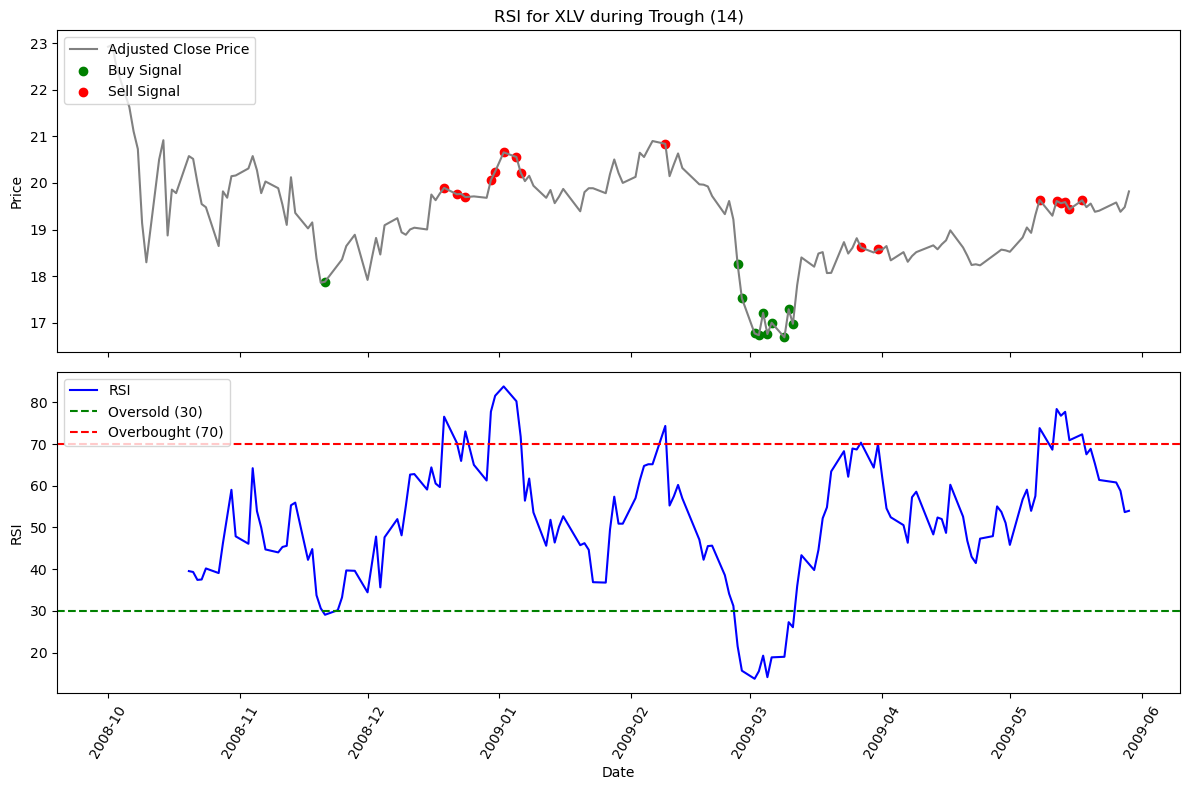

In [22]:
plot_with_rsi_signals(sector_etf_data['trough']['XLV'],'RSI for XLV during Trough (14)')

In [23]:
list_signals(sector_etf_data,sector_etf_tickers,economic_cycle_periods)['trough']['XLV']

{'Buy': [Timestamp('2008-11-21 00:00:00'),
  Timestamp('2009-02-26 00:00:00'),
  Timestamp('2009-02-27 00:00:00'),
  Timestamp('2009-03-02 00:00:00'),
  Timestamp('2009-03-03 00:00:00'),
  Timestamp('2009-03-04 00:00:00'),
  Timestamp('2009-03-05 00:00:00'),
  Timestamp('2009-03-06 00:00:00'),
  Timestamp('2009-03-09 00:00:00'),
  Timestamp('2009-03-10 00:00:00'),
  Timestamp('2009-03-11 00:00:00')],
 'Sell': [Timestamp('2008-12-19 00:00:00'),
  Timestamp('2008-12-22 00:00:00'),
  Timestamp('2008-12-24 00:00:00'),
  Timestamp('2008-12-30 00:00:00'),
  Timestamp('2008-12-31 00:00:00'),
  Timestamp('2009-01-02 00:00:00'),
  Timestamp('2009-01-05 00:00:00'),
  Timestamp('2009-01-06 00:00:00'),
  Timestamp('2009-02-09 00:00:00'),
  Timestamp('2009-03-27 00:00:00'),
  Timestamp('2009-03-31 00:00:00'),
  Timestamp('2009-05-08 00:00:00'),
  Timestamp('2009-05-12 00:00:00'),
  Timestamp('2009-05-13 00:00:00'),
  Timestamp('2009-05-14 00:00:00'),
  Timestamp('2009-05-15 00:00:00'),
  Timestamp(

In [24]:
# collect the signals as dataframes based on the period
rsi_signals = collect_signals(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers)

# display the rsi signal for a trough
rsi_signals['trough'].iloc[10:20]

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2008-10-15,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-10-16,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-10-17,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
2008-10-20,Hold,Hold,Hold,Hold,Buy,Buy,Hold,Hold,Hold,Hold,Buy
2008-10-21,Hold,Hold,Hold,Hold,Buy,Buy,Hold,Hold,Hold,Hold,Buy
2008-10-22,Hold,Hold,Hold,Hold,Buy,Buy,Hold,Hold,Hold,Hold,Buy
2008-10-23,Hold,Hold,Hold,Hold,Buy,Buy,Hold,Hold,Hold,Hold,Buy
2008-10-24,Hold,Hold,Hold,Hold,Buy,Buy,Hold,Hold,Hold,Hold,Buy
2008-10-27,Hold,Hold,Hold,Hold,Hold,Buy,Hold,Hold,Hold,Hold,Buy


### Baseline Model
Looking at the 14 day time period for average returns and average losses, use the signals to stochastically simlate the stock investment

In [25]:
# get the stochastic model
rsi_signal_return = zip_calculate_stock_roi(rsi_signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.20,0.20)

In [26]:
rsi_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,rsi_signal_return,'Mean')
rsi_return

,trough,expansion,peak,contraction,all_data
XLB,10.028037,1.899346,2.611152,0.519581,1.624213
XLI,2.284008,1.844702,5.558762,-0.744536,1.103981
XLF,5.468177,1.76276,4.406121,-5.157564,1.205709
XLK,8.61831,0.907884,0.862774,-0.946227,1.025036
XLY,6.585471,1.78102,2.601672,1.441591,1.250237
XLP,0.471768,1.581619,0.0,1.730991,1.033668
XLE,6.49321,0.600286,5.139715,0.522178,1.763276
XLV,5.114686,1.636819,1.233416,-0.127402,1.113733
VOX,5.746332,2.028802,2.796611,-1.350977,0.957482
XLU,-1.298037,1.344645,0.988368,-0.655225,1.457377


In [27]:
rsi_return.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/rsi/rsi_baseline_model.csv')

In [28]:
rsi_return.mean()

trough         5.396962
expansion      1.488934
peak           2.475625
contraction   -0.122529
all_data       1.228074
dtype: float64

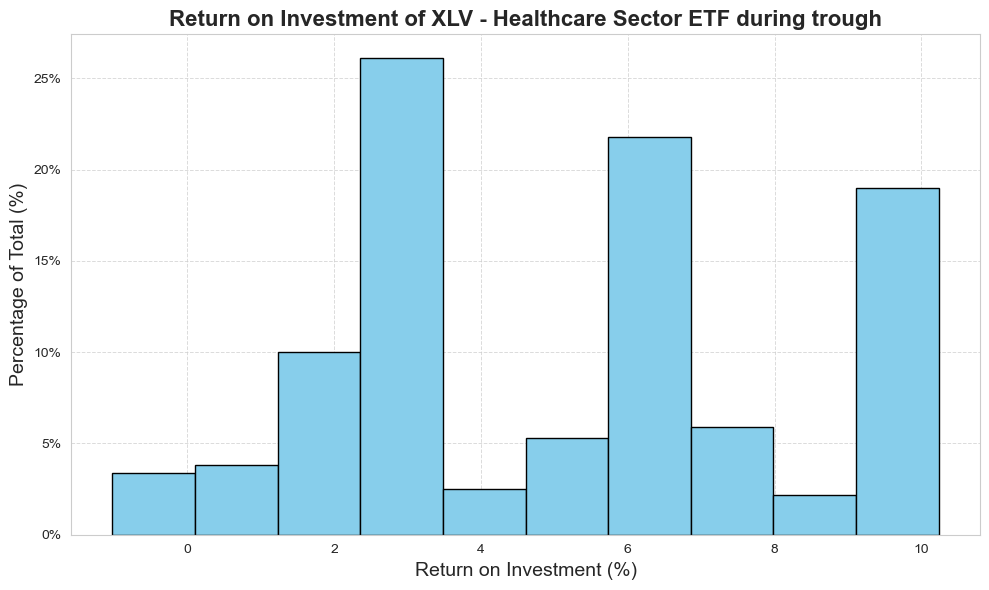

In [29]:
# plot the histogram of the XLV healthcare during a trough
plot_percentage_histogram(
    data=rsi_signal_return['trough']['XLV'],
    title=f'Return on Investment of XLV - Healthcare Sector ETF during trough',
    xlabel='Return on Investment (%)',
        ylabel='Percentage of Total (%)'
)

### Grid Search Optimized Model
The RSI values are made up of looking at a 14 day average return compared to the average loss. Let's do a correlation coefficient to see if the roi based on the length of returns has a strong correlation and should be looked at.

In [30]:
# set the length of periods to investigate
grid_returns = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]

#grid_search_length = rsi_length_optimal(sector_etf_data,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,grid_returns,1000,0,100,0.2,0.2)

In [31]:
# get the highest average return
#grid_search_length.set_index('length',inplace=True)



In [32]:
#grid_search_length.sort_values(by='trough',ascending=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


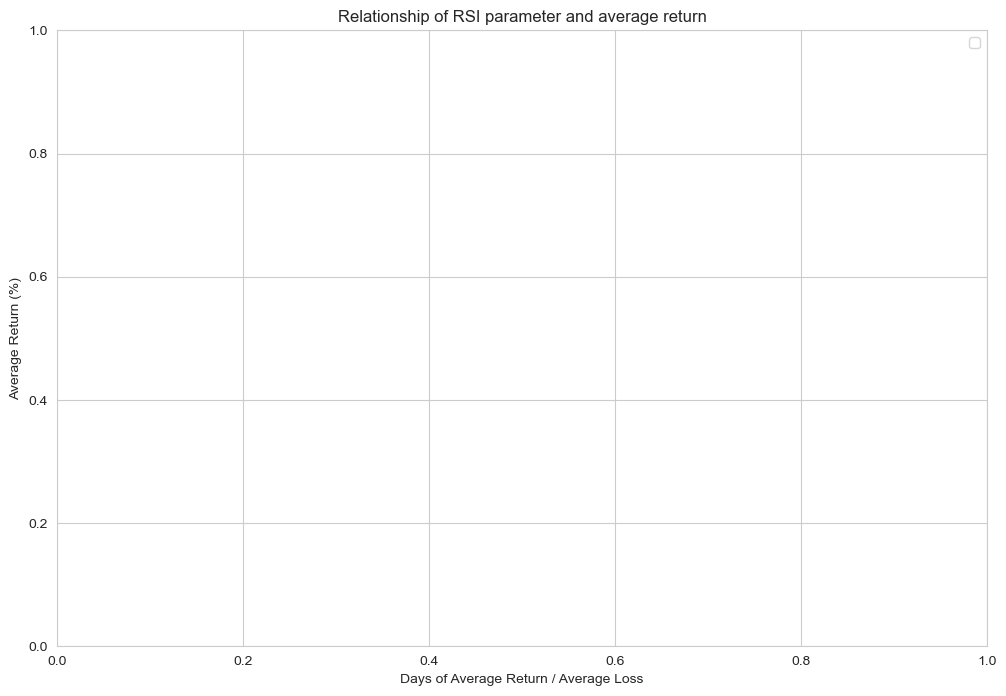

In [33]:
plt.figure(figsize=(12,8))
#plt.plot(grid_search_length.index,grid_search_length,label=grid_search_length.columns)
plt.xlabel('Days of Average Return / Average Loss')
plt.ylabel('Average Return (%)')
plt.title('Relationship of RSI parameter and average return')
plt.legend()

In [34]:
def test_rsi(length):
    etf_rsi_sector_data = rsi_value(sector_etf_data,economic_cycle_periods_list,sector_etf_tickers,length)

    etf_rsi_signal_sector_data = create_rsi_signal(etf_rsi_sector_data,economic_cycle_periods_list,sector_etf_tickers)

    signals = collect_signals(etf_rsi_signal_sector_data,economic_cycle_periods_list,sector_etf_tickers)

    returns = zip_calculate_stock_roi(signals,adj_close_sector_etf,economic_cycle_periods,economic_cycle_periods_list,sector_etf_tickers,1000,0,100,0.20,0.20)

    return returns


In [35]:
trough_optimized_parameter_returns = test_rsi(17)
overall_optimized_parameter_returns = test_rsi(5)

In [36]:
rsi_optimized_signal_return = stochastic_roi(sector_etf_tickers,economic_cycle_periods_list,trough_optimized_parameter_returns,'Mean')
rsi_optimized_signal_return

,trough,expansion,peak,contraction,all_data
XLB,10.698518,1.327614,1.119281,0.295383,1.411399
XLI,4.169144,1.250147,3.237196,0.432911,0.876861
XLF,13.22998,1.325812,1.254896,-5.391715,0.760582
XLK,7.781768,0.705394,0.0,-0.464559,0.577927
XLY,9.886453,1.193397,1.224944,0.817174,0.940694
XLP,0.934163,1.404883,0.0,1.477671,0.756618
XLE,8.472552,0.460741,5.170587,1.670234,1.619774
XLV,5.245735,1.004519,0.374007,-1.75811,0.701022
VOX,5.534202,1.702132,1.99266,-0.96676,0.766019
XLU,0.108089,1.233785,0.0,-0.552208,0.988424


In [37]:
rsi_optimized_signal_return.mean()

trough         7.007879
expansion      1.142108
peak           1.358663
contraction   -0.112953
all_data       0.922388
dtype: float64

In [38]:
rsi_optimized_signal_return.to_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Financial Capstone Project/data/performance_data/rsi/parameter_optimal.csv')

### Incoroporate Rolling Average of RSI so that it is not static

In [39]:
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,RSI,Signal,Buy Data,Sell Data
Date,,,,,,,,,,
2008-10-01,30.100000,30.480000,30.100000,30.250000,22.927485,6053600,NaN,Hold,NaN,NaN
2008-10-02,30.250000,30.590000,29.930000,30.299999,22.965382,6353400,NaN,Hold,NaN,NaN
2008-10-03,30.600000,30.600000,29.650000,29.650000,22.472727,6814400,NaN,Hold,NaN,NaN
2008-10-06,29.400000,29.879999,27.410000,28.540001,21.631424,8545000,NaN,Hold,NaN,NaN
2008-10-07,28.719999,28.780001,27.389999,27.850000,21.108452,5060200,2.000030,Buy,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2009-05-22,25.280001,25.400000,25.070000,25.290001,19.404516,3655700,47.500482,Hold,NaN,NaN
2009-05-26,25.190001,25.660000,24.889999,25.520000,19.580996,4412900,46.154949,Hold,NaN,NaN
2009-05-27,25.549999,25.600000,25.219999,25.260000,19.381493,4591100,42.352807,Hold,NaN,NaN


In [45]:
test = sector_etf_data.copy()
rolling_window = 14  # Number of days for RSI rolling calculations
test['trough']['XLK']['Middle Band'] = sector_etf_data['trough']['XLV']['RSI'].rolling(rolling_window).mean()
test['trough']['XLK']['Upper Bound'] = test['trough']['XLV']['Middle Band'] + sector_etf_data['trough']['XLK']['RSI'].rolling(rolling_window).std()
test['trough']['XLK']['Lower Bound'] = test['trough']['XLV']['Middle Band'] - sector_etf_data['trough']['XLK']['RSI'].rolling(rolling_window).std()


In [47]:
data =test['trough']['XLK']

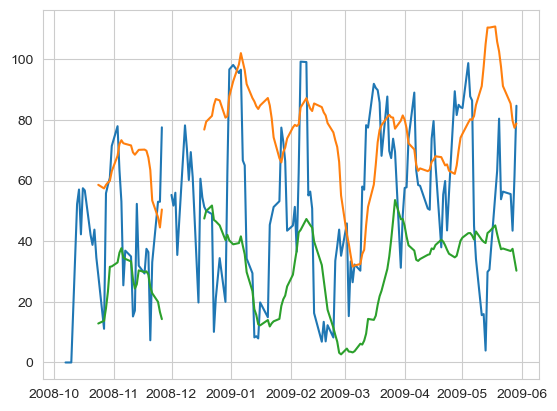

In [48]:
plt.plot(data['RSI'])
plt.plot(data['Upper Bound'])
plt.plot(data['Lower Bound'])

In [43]:
data['Middle Band'].head(50)

Date
2008-10-01          NaN
2008-10-02          NaN
2008-10-03          NaN
2008-10-06          NaN
2008-10-07          NaN
2008-10-08          NaN
2008-10-09          NaN
2008-10-10          NaN
2008-10-13          NaN
2008-10-14          NaN
2008-10-15          NaN
2008-10-16          NaN
2008-10-17          NaN
2008-10-20          NaN
2008-10-21          NaN
2008-10-22          NaN
2008-10-23          NaN
2008-10-24    35.731728
2008-10-27    35.588869
2008-10-28    38.223907
2008-10-29    41.360286
2008-10-30    45.730983
2008-10-31    47.387915
2008-11-03    50.581637
2008-11-04    54.141519
2008-11-05    55.508715
2008-11-06    53.524597
2008-11-07    53.147370
2008-11-10    52.467637
2008-11-11    48.377599
2008-11-12    46.456151
2008-11-13    47.579851
2008-11-14    50.265887
2008-11-17    50.022969
2008-11-18    49.953571
2008-11-19    48.303966
2008-11-20    44.168214
2008-11-21    38.135513
2008-11-24    33.948833
2008-11-25    30.603464
2008-11-26    32.384185
2008-11-28 